In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, errno
from scipy.special import expit as activation_function
from scipy.stats import truncnorm
from scipy import stats
from sklearn.metrics import confusion_matrix
import copy
import time
import datetime as dt
from scipy.spatial import distance
from BackProp import NeuralNetwork

In [2]:
def getProbDistribution(list_vals, max_bound, min_bound, bucket_count):
    # max_bound = np.max(list_vals)
    # min_bound = np.min(list_vals)
    
    bucket_size = (max_bound - min_bound)/bucket_count
        
    bkt_frequency = {}
    
    bkt_low = min_bound
    bkt_high = 0.0
    
    for i in range(bucket_count):
        bkt_high = bkt_low + bucket_size
        
        bkt_frequency[bkt_high] = 0
        
        bkt_low = bkt_high
    
    for i in range(len(list_vals)):
        for k in bkt_frequency:
            if list_vals[i] <= k:
                bkt_frequency[k] = bkt_frequency[k] + 1
                break
                
    bkt_pdf = []
    bkt_cdf = []
    bkt_vals = []
    
    cum_sum = 0.0
    obs_count = len(list_vals)
    
    for k in bkt_frequency:
        prob_val = bkt_frequency[k]/obs_count
        cum_sum = cum_sum + prob_val
        
        bkt_pdf.append(prob_val)
        bkt_cdf.append(cum_sum)
        bkt_vals.append(k)
        
    return bkt_vals, bkt_pdf, bkt_cdf

In [3]:
def kldiv(p, q):
    if len(p) != len(q):
        print('Distributions do not match! Exiting')
        return -1
    
    kldiv = 0.0
    eps = 0.0001
    
    for i in range(len(p)):
        plog = 0.0
        qlog = 0.0
        
        if p[i] > 0:
            plog = np.log(p[i])
        else:
            plog = np.log(eps)
            
        if q[i] > 0:
            qlog = np.log(q[i])
        else:
            qlog = np.log(eps)
            
        kldiv = kldiv + p[i] * (plog - qlog)
        
    return kldiv

Max : 1.0
Min : 0.0
first item [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1

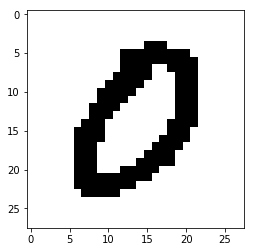

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

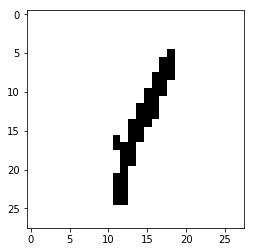

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

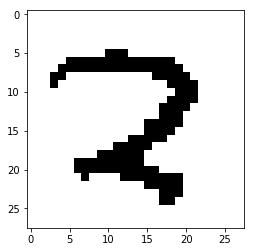

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

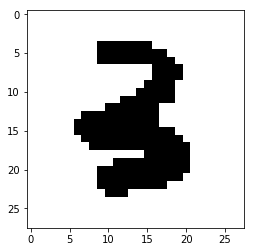

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

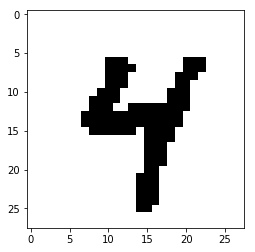

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

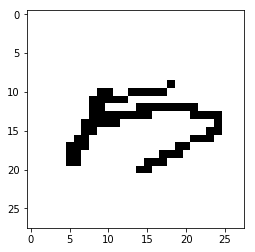

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

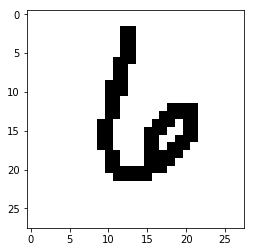

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

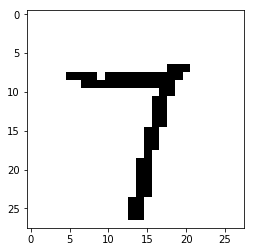

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

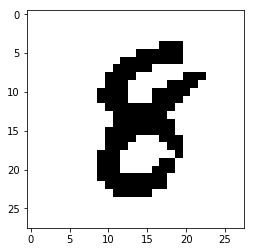

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

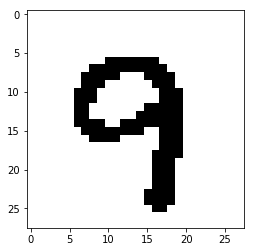

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

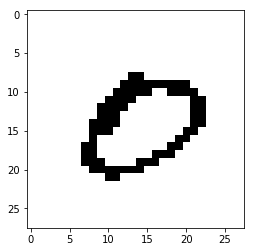

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

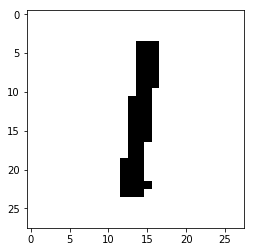

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

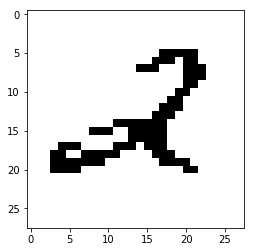

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

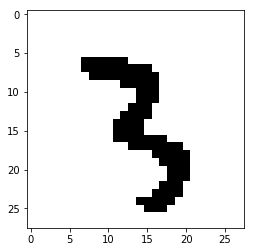

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

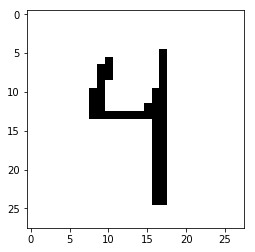

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

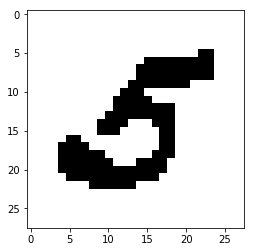

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

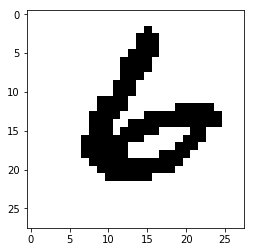

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

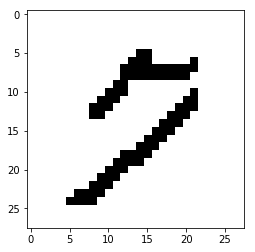

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

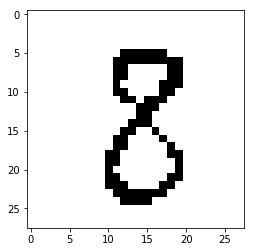

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

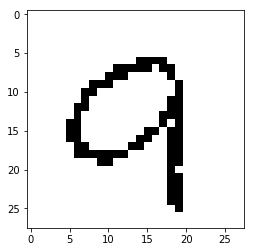

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

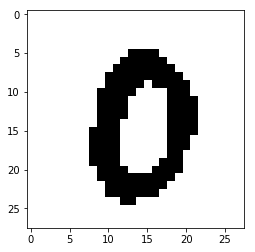

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

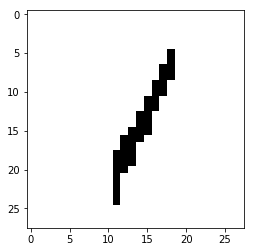

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

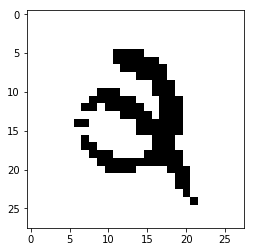

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

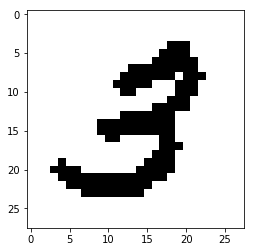

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

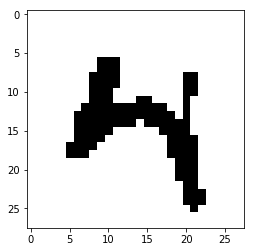

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

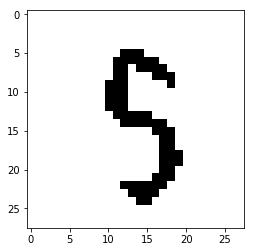

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

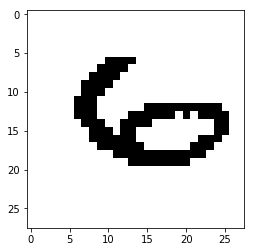

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

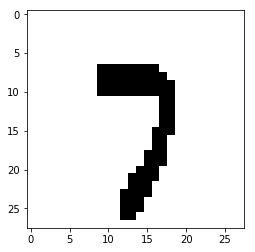

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

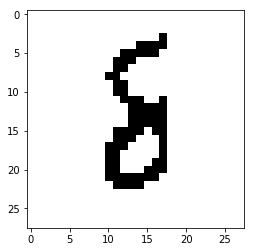

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

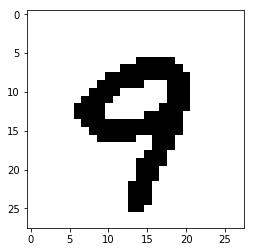

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

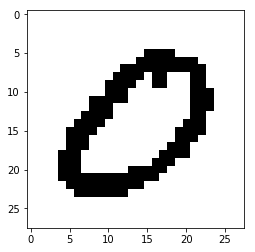

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

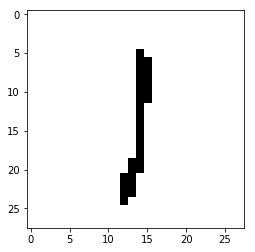

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

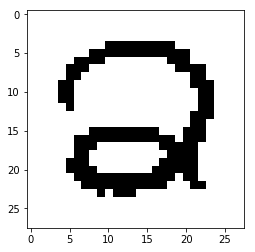

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

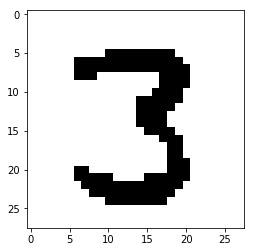

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

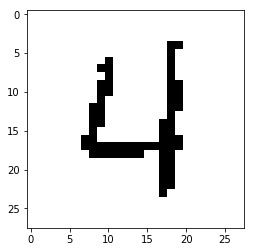

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

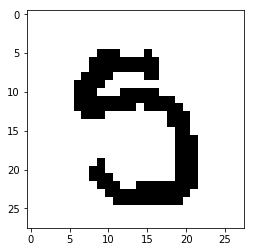

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

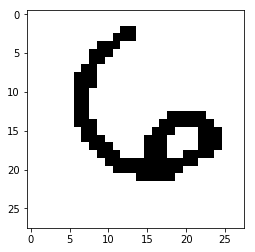

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

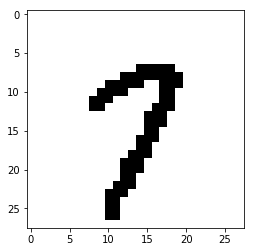

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

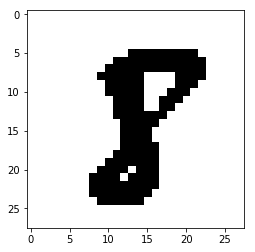

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

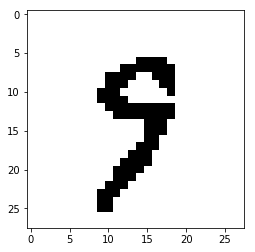

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

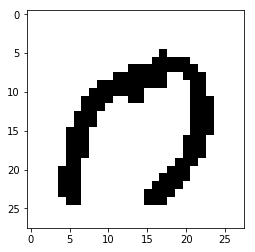

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

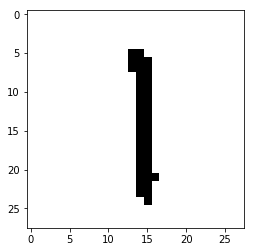

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

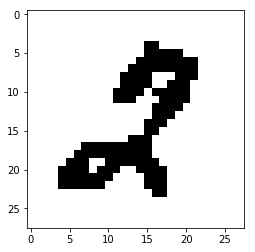

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

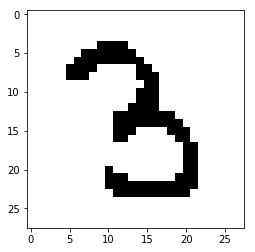

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

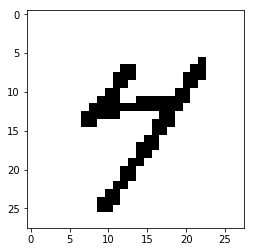

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

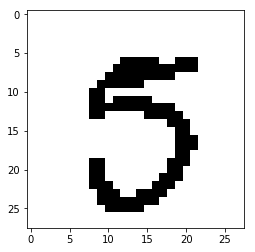

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

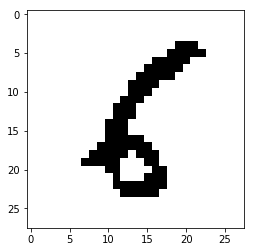

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

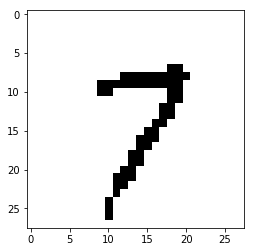

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

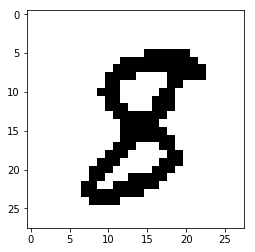

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
  -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -

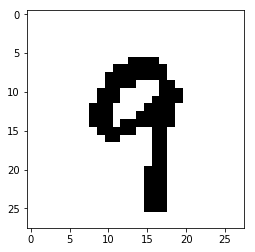

In [4]:
read_dir_name = "SimulationResults/Pattern_Angles_20180827/"
file_name_str = "patternset1to5_series.txt"
file_name = read_dir_name + file_name_str

file_name_str = "patternset1to5.txt"


#setting up the training data
text_array = np.genfromtxt(file_name_str, delimiter=' ')
#print(text_array)




#total items = 50
text_array_float = text_array.astype(np.float)
text_array_float[text_array_float > 0] = 1
text_array_float[text_array_float <= 0] = 0
max_bound = np.max(text_array_float)
min_bound = np.min(text_array_float)

print('Max :', np.max(text_array_float))
print('Min :', np.min(text_array_float))

print("first item",text_array_float[0])
print("last item",text_array_float[49])

#print(text_array_float)
text_array_int = text_array.astype(np.int)
print('Array Shape:', text_array_int.shape)
print('Dtype:', text_array_int.dtype)
text_array_int[text_array_int > 0] = 1
text_array_int[text_array_int <= 0] = 0
text_array_int = text_array.astype(np.int)







for i in range(50):
    print(np.resize(text_array_int[0],(28,28)))
    img = text_array_int[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()
    


In [5]:
#assign label for training data
lr= np.arange(10)
for label in range(10):
    print("label,label")
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)
    

no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 
llistToAdd=[]
llabels=[]
llistToAdd.append('0')


llistToAdd.extend(('1','2','3','4','5','6','7','8','9','0','1','2','3','4','5','6','7','8','9','0','1','2','3','4','5','6','7','8','9','0','1','2','3','4','5','6','7','8','9','0','1','2','3','4','5','6','7','8','9'))

for i in range(len(llistToAdd)):
    print("i==",i)
    print(llistToAdd[i])
    item = llistToAdd[i]
    intItem = int(item)
    # transform labels into one hot representation
    train_labels_one_hot = (lr==intItem).astype(np.float)


    # we don't want zeroes and ones in the labels neither:
    train_labels_one_hot[train_labels_one_hot==1] = 0.99
    train_labels_one_hot[train_labels_one_hot==0] = 0.01
    print("train_labels_one_hot: ", train_labels_one_hot)
    llabels.append(train_labels_one_hot)
    #train_labels.append(train_labels_one_hot)

train_labels = np.array(llabels)
print("size", train_labels.size)
count = train_labels.size


print('Array Shape:', text_array.shape)
print('Array Shape:', text_array_int[0].shape)
print('Array Shape:', train_labels.shape)
print('Array Shape:', train_labels_one_hot.shape)




#for x in range(len(train_labels)): 
np.set_printoptions(threshold=np.inf)
print(train_labels)
print(type(train_labels))            # Prints "<class 'numpy.ndarray'>"
print(train_labels.shape) 
print(train_labels[0])

label,label
label:  0  in one-hot representation:  [1 0 0 0 0 0 0 0 0 0]
label,label
label:  1  in one-hot representation:  [0 1 0 0 0 0 0 0 0 0]
label,label
label:  2  in one-hot representation:  [0 0 1 0 0 0 0 0 0 0]
label,label
label:  3  in one-hot representation:  [0 0 0 1 0 0 0 0 0 0]
label,label
label:  4  in one-hot representation:  [0 0 0 0 1 0 0 0 0 0]
label,label
label:  5  in one-hot representation:  [0 0 0 0 0 1 0 0 0 0]
label,label
label:  6  in one-hot representation:  [0 0 0 0 0 0 1 0 0 0]
label,label
label:  7  in one-hot representation:  [0 0 0 0 0 0 0 1 0 0]
label,label
label:  8  in one-hot representation:  [0 0 0 0 0 0 0 0 1 0]
label,label
label:  9  in one-hot representation:  [0 0 0 0 0 0 0 0 0 1]
i== 0
0
train_labels_one_hot:  [0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
i== 1
1
train_labels_one_hot:  [0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
i== 2
2
train_labels_one_hot:  [0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
i== 3
3
train_labels_

In [6]:
start_time = time.time()

linColMap = {}
linColMap[0] = 'k-'
linColMap[1] = 'r-'
linColMap[2] = 'b-'
linColMap[3] = 'g-'
linColMap[4] = 'c-'
linColMap[5] = 'm-'
linColMap[6] = 'y-'
linColMap[7] = 'b--'
linColMap[8] = 'g--'
linColMap[9] = 'r--'
linColMap[10] = 'k--'
linColMap[11] = 'c--'
linColMap[12] = 'm--'
linColMap[13] = 'y--'
linColMap[14] = 'k-o'
linColMap[15] = 'r-o'
linColMap[16] = 'b-o'
linColMap[17] = 'g-o'
linColMap[18] = 'c-o'
linColMap[19] = 'm-o'
linColMap[20] = 'y-o'




In [7]:
neuron_count = 784

#hidden_nodes = 784

#hidden_nodes_list = [100, 250, 500, 750, 784, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
#hidden_nodes_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

#hidden_nodes_list = [10, 20]

#hidden_nodes_list = [100, 250, 500, 784, 1000]
#hidden_nodes_list = [100, 250, 500, 750, 784, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
hidden_nodes_list = [784]

min_noise = 0.1
max_noise = 1.0 #0.2 # 1.0
noise_int = 0.025 #0.05 #0.025

noise_ratio = min_noise

dateStr = dt.date.today().strftime("%Y%m%d")
dirName = "SimulationResults/Patt_MisClassfn_Mean_" + dateStr + "/"

if not os.path.exists(dirName):
    os.makedirs(dirName)

interval_count = int((max_noise - min_noise)/noise_int)
fileStr = 'Patt_Misclassification_Mean_P' + str(text_array_float.shape[0]) + '_BP_hmin' + str(np.min(hidden_nodes_list)) + '_hmax' + str(np.max(hidden_nodes_list))
fileName = dirName + fileStr
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)



<Figure size 1332x756 with 0 Axes>

Hidden Node Count: 784
shape
training_data Array Shape: (50, 784)
train_labels_one_hot Array Shape labels: (50, 10)
{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 5: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 6: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 7: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

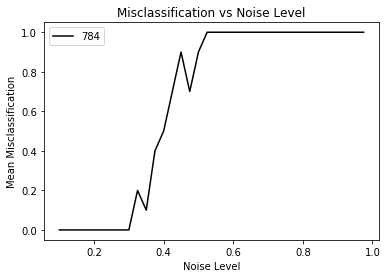

In [8]:
line_id = 0
image_pixels = 28 * 28
for hidden_nodes in hidden_nodes_list:
    print('Hidden Node Count:', hidden_nodes)
    

    #r = RBM(num_visible = neuron_count, num_hidden = hidden_nodes)
    network = NeuralNetwork(no_of_in_nodes=image_pixels, 
                                       no_of_out_nodes=10, 
                                       no_of_hidden_nodes=hidden_nodes,
                                       learning_rate=0.2,
                                       bias=0.2)
                                          
    #network = NeuralNetwork(no_of_in_nodes=image_pixels, 
     #                                  no_of_out_nodes=10, 
      #                                 no_of_hidden_nodes=hidden_nodes,
       #                                learning_rate=learning_rate,
        #                               bias=bias)
            
    training_data = np.copy(text_array_float)
    train_labels_one_hot = np.copy(train_labels)
    print("shape",)
    print('training_data Array Shape:', training_data.shape)

    
    print('train_labels_one_hot Array Shape labels:', train_labels_one_hot.shape)
    weights = []
    errors = []
    e1 = []
    errors = network.train(training_data, train_labels_one_hot, epochs=50, 
                                       intermediate_results=True) 
    '''
    #print('BP Weights', weights)
    print('BP errors', len(errors))
    e1 = errors
    print('BP e1', len(e1))

    for i in range(len(e1)):
        print("i---",i, e1[i])
        '''
    '''
    print(errors[9])
    serieserr = {}
    pcl_err_array = []
    pcl_err_array = np.array(errors)
    ep = []
    for i in range(1,11):
        ep.append(i)
    
    for i in range(len(pcl_err_array)):
        print("in")
        #print(errors[i])
        #pcl_err_array = np.array(pcl_err_list)
         #   pcl_mean_list = pcl_err_array.mean(axis=0)

        #serieserr.append(pcl_err_array[i])
  
    #print('Training Data Shape:', training_data.shape)
    plt.plot(ep, pcl_err_array)
                                     
    print("end training")
    
 '''
    
    patt_miscl_noise = {}
    sim_count = 10
    patt_class_err = {}
    patt_noise_series = {}

    for idx in range(1, 11):
        idx_start = 5 * (idx - 1)
        idx_end = 5 * idx
        patt_idx_list = np.array(text_array_float[idx_start:idx_end])

        if idx not in patt_class_err:
            patt_class_err[idx - 1] = []
            patt_noise_series[idx - 1] = []

        noise_ratio = min_noise

        while noise_ratio < max_noise:
            flip_count = int(noise_ratio * neuron_count)

            miscl_count = 0

            for src_idx in range(patt_idx_list.shape[0]):
                ##print("src_idx",src_idx)
                for sim_iter in range(sim_count):                    
                    #print("sim_iter",sim_iter)

                    idx_list = np.random.choice(neuron_count,flip_count,replace=False)

                    user = np.copy(text_array_float[src_idx])
                    lbl = np.copy(train_labels_one_hot[src_idx])

                    user[idx_list] = (user[idx_list] + 1) % 2

                    user_list = []
                    user_list.append(user)
                    lbl_list = []
                    lbl_list.append(lbl)
                    #print("user",user)
                    #print("user_list",user_list)
                    #print("lbl_list",lbl)

                    #print(len(lbl_list))
                    #print(len(user_list))
                    
                    #evaluate
                    test_corrects, test_wrongs = 0, 0
                    for i in range(len(user_list)):
                        #print("einside eval")
                        #print("labelsres eval",lbl_list[i])
                        #print("user_list eval",user_list[i])
                        res = network.run(user_list[i])
                        #print("res eval",res)
                        res_max = res.argmax()
                        #print("res res_max",res_max)
                        #print("lbl_list max",lbl_list[i].argmax())
                        if res_max == lbl_list[i].argmax():               
                            test_corrects += 1
                        else:                
                            test_wrongs += 1
                        
    
                    #test_corrects, test_wrongs = network.evaluate(np.array(user_list), np.array(lbl_list))
                                                            
                    
                    #print("test_corrects",test_corrects)
                    #print("test_wrongs",test_wrongs)
                    #ecalled_vector = r.run_hidden(r.run_visible(np.array(user_list)))

                    #ham_dist_vals = []

                    #or i in range(text_array_float.shape[0]):
                     #   hamming_dist = np.count_nonzero(text_array_float[i] != recalled_vector)

                      #  ham_dist_vals.append(hamming_dist)

                    #ham_dist_min_val = np.min(ham_dist_vals)
                    #ham_dist_min_idx = np.argmin(ham_dist_vals)

                    #if (src_idx != ham_dist_min_idx):
                    #miscl_count = miscl_count + 1

            #patt_class_err[idx - 1].append(miscl_count/50.0)
            patt_class_err[idx - 1].append(test_wrongs)
            patt_noise_series[idx - 1].append(noise_ratio)

            noise_ratio = noise_ratio + noise_int

    #print('Min. Noise Levels')
    print(patt_class_err)

    pcl_err_list = []

    for patt_idx in patt_class_err:
        pcl_err_list.append(patt_class_err[patt_idx])

    pcl_err_array = np.array(pcl_err_list)
    print('Array Shape:', pcl_err_array.shape)

    pcl_mean_list = pcl_err_array.mean(axis=0)

    print('Mean Array Shape:', pcl_mean_list.shape)
    print(pcl_mean_list)
    print(patt_noise_series[0])

    plt.plot(patt_noise_series[0], pcl_mean_list, linColMap[line_id], label=str(hidden_nodes))

    line_id = line_id + 1

plt.legend()
plt.xlabel('Noise Level')
plt.ylabel('Mean Misclassification')
plt.title('Misclassification vs Noise Level')
#plt.ylim(0.0,0.1)

fig.savefig(fileName)

end_time = time.time()
print('Total Time: ', (end_time - start_time)/60.0, ' mins')
   